In [1]:
%run 'data_preparation.ipynb'

In [2]:
#%store -r schoolholidays
#%store -r year
#%store -r data

In [3]:
from fbprophet import Prophet
import ml_metrics as metrics

In [4]:
#overall data
per_day = year.pivot_table(index=['BOOKING_DATE'],values=['BOOKING_HAL_ID'], aggfunc=lambda x: len(x.unique()))

In [5]:
#citylist = year.CITY_RENTAL_ZONE.unique()
#citylist

In [6]:
#number of bookings for a specific city
#city = year.loc[year['CITY_RENTAL_ZONE']=='Hamburg']
#per_day = city.pivot_table(index=['BOOKING_DATE'],values=['BOOKING_HAL_ID'], aggfunc=lambda x: len(x.unique()))

In [47]:
#fullcity = data.loc[data['CITY_RENTAL_ZONE']=='Hamburg']
per_day_2017 = data.pivot_table(index=['BOOKING_DATE'],values=['BOOKING_HAL_ID'], aggfunc=lambda x: len(x.unique()))

In [8]:
per_day.reset_index(inplace=True)
per_day.tail()

,BOOKING_DATE,BOOKING_HAL_ID
1091,2016-12-27,273
1092,2016-12-28,263
1093,2016-12-29,301
1094,2016-12-30,315
1095,2016-12-31,225


In [9]:
#log-transform as a way to remove some of the anomolies
per_day.BOOKING_HAL_ID = np.log(per_day.BOOKING_HAL_ID)

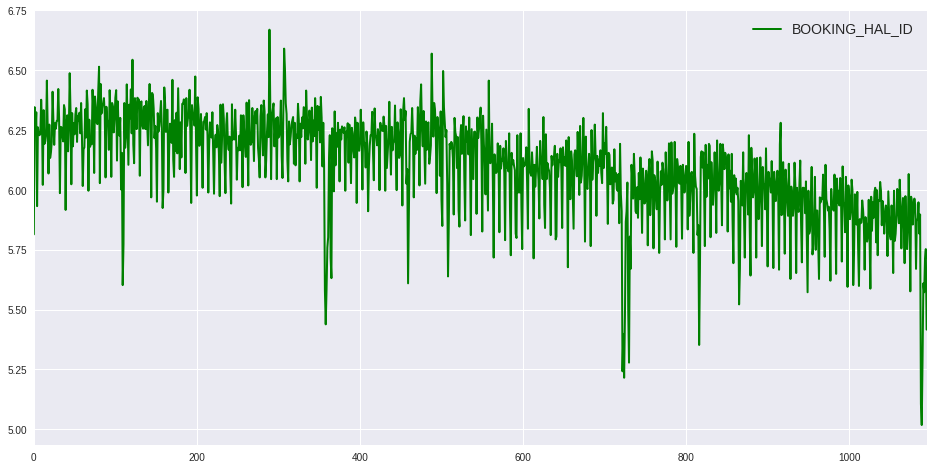

In [10]:
per_day.plot(color='green')

# Prediction without holiday data

In [11]:
# Prophet requires columns ds (Date) and y (value)
per_day = per_day.rename(columns={'BOOKING_DATE': 'ds', 'BOOKING_HAL_ID': 'y'})
# Make the prophet model and fit on the data
per_day_prophet = Prophet(changepoint_prior_scale=0.4, changepoints=['2014-04-16', '2014-12-17','2014-12-17', '2015-01-21', '2015-05-07', '2015-08-20', '2016-01-07', '2016-04-21'])
#m = Prophet(weekly_seasonality=False)
per_day_prophet.add_seasonality(name='monthly', period=30.5, fourier_order=5, prior_scale=0.2)
per_day_prophet.fit(per_day)
# Make a future dataframe for 2 years
per_day_forecast = per_day_prophet.make_future_dataframe(periods=730, freq='D')
# Make predictions
per_day_forecast = per_day_prophet.predict(per_day_forecast)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/jawahar/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



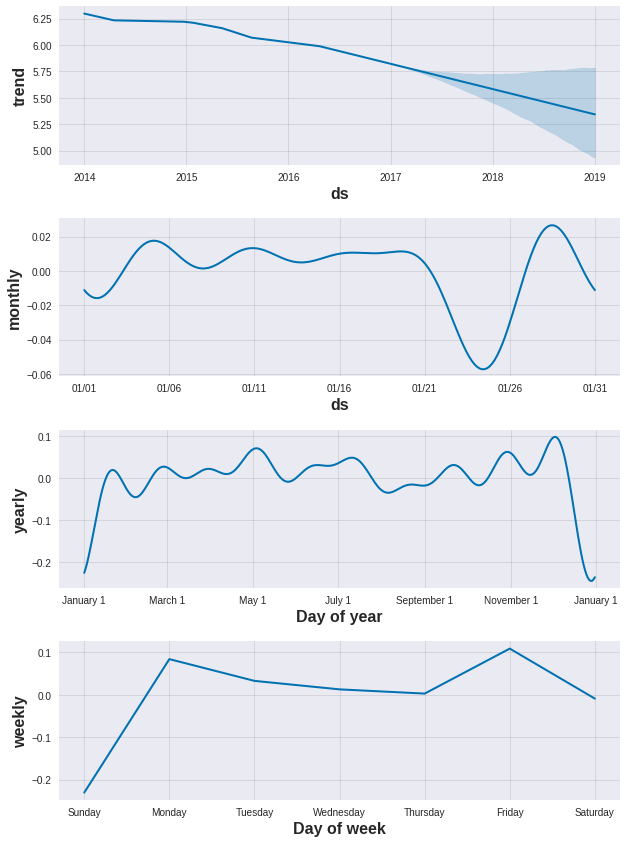

In [12]:
per_day_prophet.plot_components(per_day_forecast);

In [13]:
viz_df = per_day.join(per_day_forecast[['yhat', 'yhat_lower','yhat_upper']], how = 'outer')
viz_df['yhat_scaled']=np.exp(viz_df['yhat'])
viz_df['y']=np.exp(viz_df['y'])

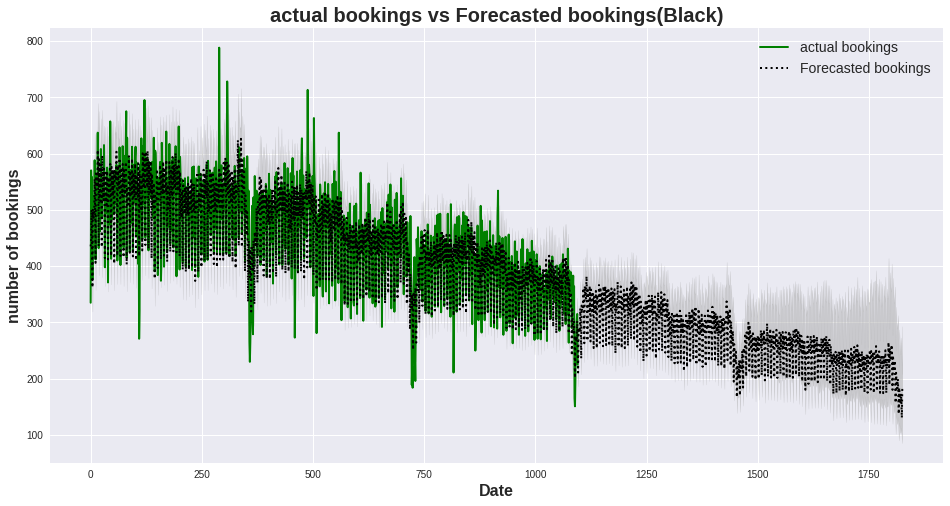

In [14]:
fig, ax1 = plt.subplots()
ax1.plot(viz_df.y, color='green')
ax1.plot(viz_df.yhat_scaled, color='black', linestyle=':')
ax1.fill_between(viz_df.index, np.exp(viz_df['yhat_upper']), np.exp(viz_df['yhat_lower']), alpha=0.5, color='darkgray')
ax1.set_title('actual bookings vs Forecasted bookings(Black)')
ax1.set_ylabel('number of bookings')
ax1.set_xlabel('Date')

L=ax1.legend() #get the legend
L.get_texts()[0].set_text('actual bookings') #change the legend text for 1st plot
L.get_texts()[1].set_text('Forecasted bookings') #change the legend text for 2nd plot

In [15]:
per_day_prophet.changepoints

DatetimeIndex(['2014-04-16', '2014-12-17', '2014-12-17', '2015-01-21',
               '2015-05-07', '2015-08-20', '2016-01-07', '2016-04-21'],
              dtype='datetime64[ns]', freq=None)

In [16]:
#changepoints=['2014-04-16', '2014-12-17','2014-12-17', '2015-01-21', '2015-05-07', '2015-08-20', '2016-01-07', '2016-04-21']

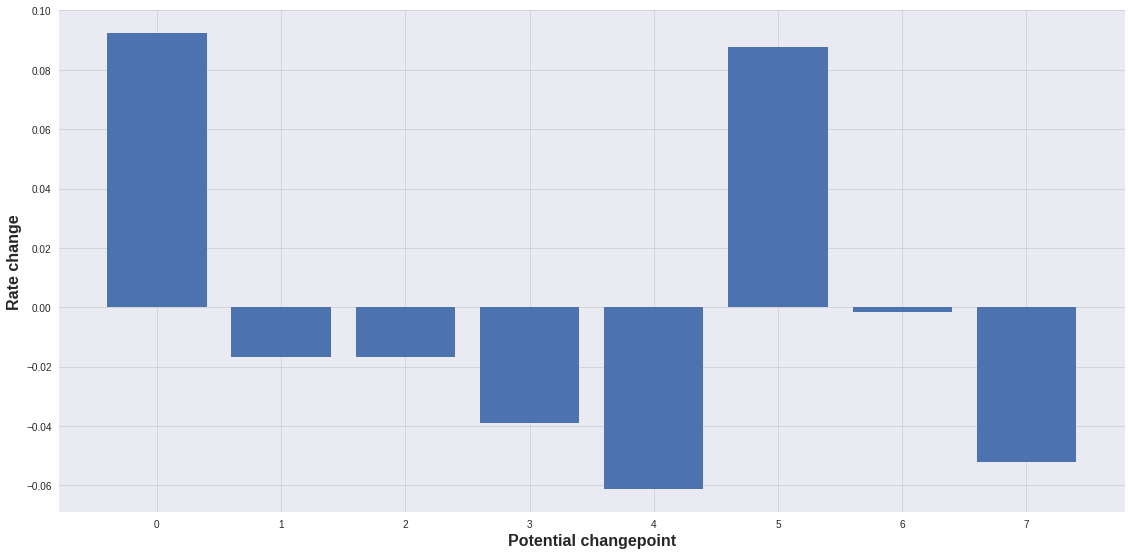

In [17]:
deltas = per_day_prophet.params['delta'].mean(0)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111)
ax.bar(range(len(deltas)), deltas)
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_ylabel('Rate change')
ax.set_xlabel('Potential changepoint')
fig.tight_layout()

# Effect of Changepoint Prior Scale

In [18]:
cpscale = pd.DataFrame(per_day)

In [19]:
# Try 4 different changepoints
for changepoint in [0.1, 0.2, 0.27 ,0.3, 0.31, 0.32, 0.33, 0.4, 0.43, 0.45, 0.49]:
    model = Prophet(daily_seasonality=False, changepoint_prior_scale=changepoint)
    model.fit(cpscale)
    
    future = model.make_future_dataframe(periods=730, freq='D')
    future = model.predict(future)
    
    cpscale[changepoint] = future['yhat']
    #cpscale.columns = cpscale.columns.astype(str)
    print("RMSE for Changepoint Prior Scale "+ str(changepoint))
    print(metrics.rmse(cpscale['y'], cpscale[changepoint]))
    print('\n')
    

/home/jawahar/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



RMSE for Changepoint Prior Scale 0.1
0.10412370682799554


RMSE for Changepoint Prior Scale 0.2
0.10403389041649946


RMSE for Changepoint Prior Scale 0.27
0.10398764560465983


RMSE for Changepoint Prior Scale 0.3
0.10397629651046672


RMSE for Changepoint Prior Scale 0.31
0.1039717438450917


RMSE for Changepoint Prior Scale 0.32
0.10396728740784396


RMSE for Changepoint Prior Scale 0.33
0.10395268680772032


RMSE for Changepoint Prior Scale 0.4
0.10393827328565712


RMSE for Changepoint Prior Scale 0.43
0.10390048758847761


RMSE for Changepoint Prior Scale 0.45
0.10389836645919175


RMSE for Changepoint Prior Scale 0.49
0.10390429458107876




# Prediction with holiday data

In [20]:
schoolholidays.columns

Index(['Berlin', 'Hamburg', 'BadenWürttemberg', 'Bayern', 'Brandenburg',
       'Bremen', 'Hessen', 'MecklenburgVorpommern', 'Niedersachsen',
       'NordrheinWestfalen', 'RheinlandPfalz', 'Saarland', 'Sachsen',
       'SachsenAnhalt', 'SchleswigHolstein', 'Thüringen'],
      dtype='object')

In [21]:
holidays = pd.DataFrame({
  'holiday': 'school-holidays',
  'ds': schoolholidays.Hamburg,
  'lower_window': 0,
  'upper_window': 2,
});

In [22]:
holidays.head()

,ds,holiday,lower_window,upper_window
0,2014-01-01,school-holidays,0,2
1,2014-01-02,school-holidays,0,2
2,2014-01-03,school-holidays,0,2
3,2014-01-31,school-holidays,0,2
4,2014-03-03,school-holidays,0,2


In [23]:
# Make the prophet model and fit on the data
model = Prophet(holidays=holidays, changepoint_prior_scale=0.4, changepoints=['2014-04-16', '2014-12-17','2014-12-17', '2015-01-21', '2015-05-07', '2015-08-20', '2016-01-07', '2016-04-21'])
# Add daily seasonility
model.add_seasonality(name='daily', period=24, fourier_order=5, prior_scale=0.1);
# Add monthly seasonility
model.add_seasonality(name='monthly', period=30.5, fourier_order=5, prior_scale=0.1);
# Fit the data
model.fit(per_day)
# Make prediction for next 2 years
future = model.make_future_dataframe(periods=730, freq = 'D')
forecast = model.predict(future)

INFO:fbprophet.forecaster:Found custom seasonality named "daily", disabling built-in daily seasonality.
/home/jawahar/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



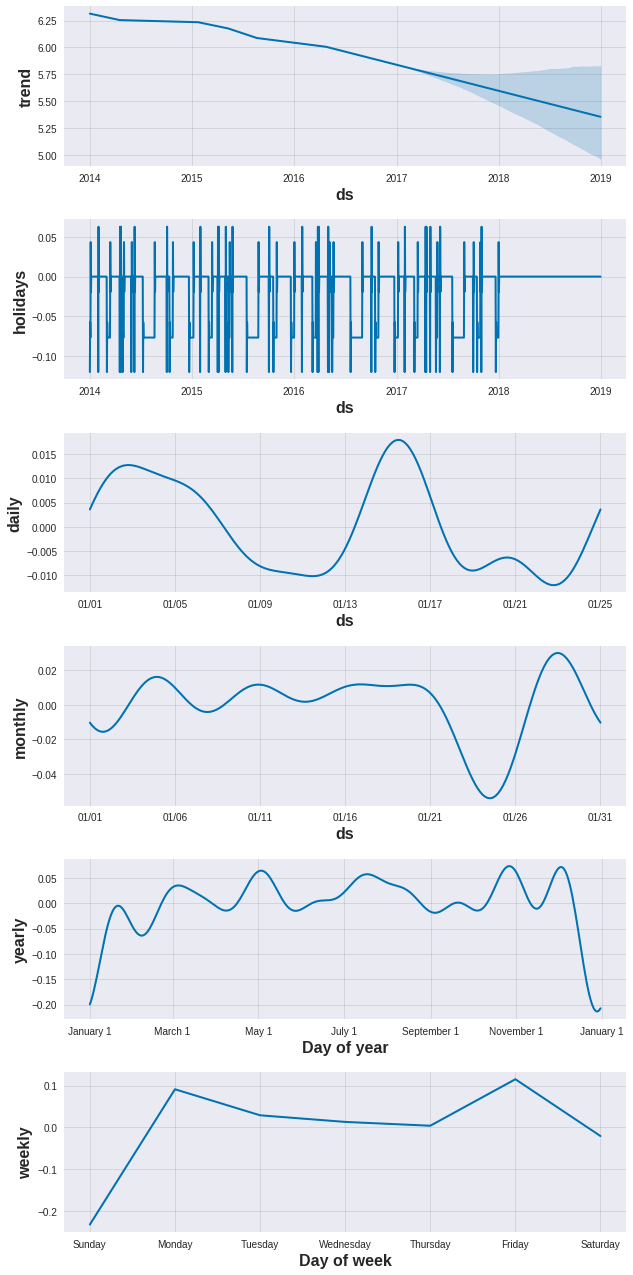

In [24]:
model.plot_components(forecast);

In [25]:
hviz_df = per_day.join(forecast[['yhat', 'yhat_lower','yhat_upper']], how = 'outer')

In [26]:
hviz_df['yhat_scaled']=np.exp(hviz_df['yhat'])
hviz_df['y']=np.exp(hviz_df['y'])

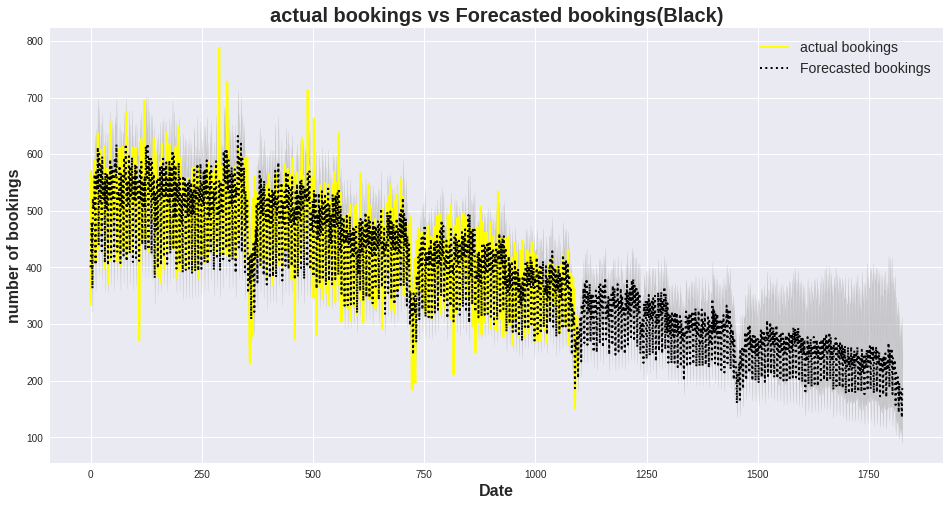

In [27]:
fig, ax1 = plt.subplots()
ax1.plot(hviz_df.y, color='yellow')
ax1.plot(hviz_df.yhat_scaled, color='black', linestyle=':')
ax1.fill_between(hviz_df.index, np.exp(hviz_df['yhat_upper']), np.exp(hviz_df['yhat_lower']), alpha=0.5, color='darkgray')
ax1.set_title('actual bookings vs Forecasted bookings(Black)')
ax1.set_ylabel('number of bookings')
ax1.set_xlabel('Date')

L=ax1.legend() #get the legend
L.get_texts()[0].set_text('actual bookings') #change the legend text for 1st plot
L.get_texts()[1].set_text('Forecasted bookings') #change the legend text for 2nd plot

# changepoints

In [28]:
model.changepoints

DatetimeIndex(['2014-04-16', '2014-12-17', '2014-12-17', '2015-01-21',
               '2015-05-07', '2015-08-20', '2016-01-07', '2016-04-21'],
              dtype='datetime64[ns]', freq=None)

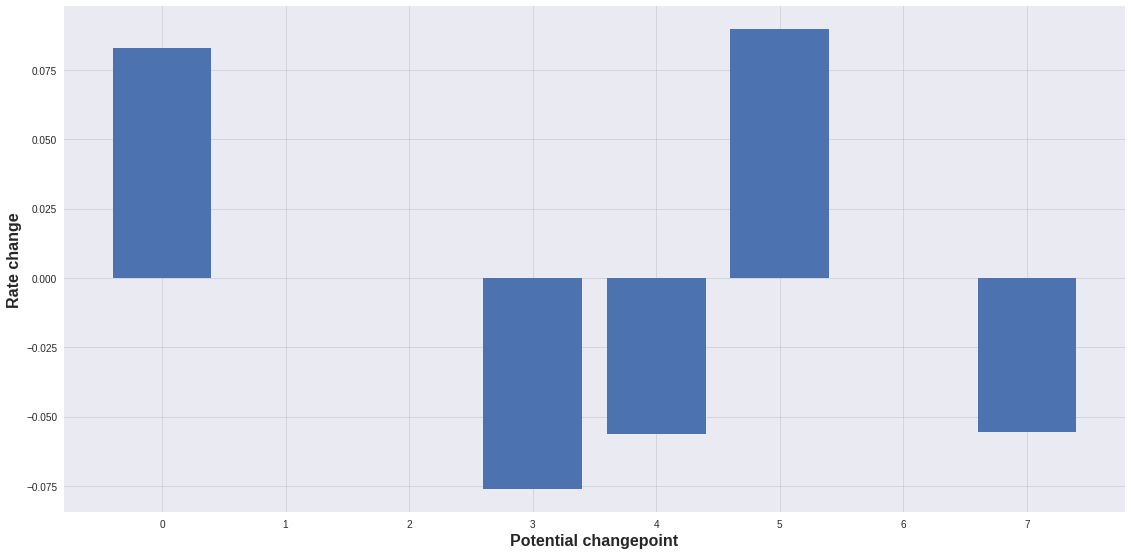

In [29]:
deltas = model.params['delta'].mean(0)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111)
ax.bar(range(len(deltas)), deltas)
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_ylabel('Rate change')
ax.set_xlabel('Potential changepoint')
fig.tight_layout()

In [30]:
compared_df = forecast.join(per_day_forecast, rsuffix="_no_holiday")

Creating compared_viz DataFrame

In [31]:
compared_viz_df= compared_df[['ds','yhat', 'yhat_no_holiday']]

compared_viz_df['yhat']= np.exp(compared_viz_df['yhat'])
compared_viz_df['yhat_no_holiday']= np.exp(compared_viz_df['yhat_no_holiday'])

cols = ['yhat', 'yhat_no_holiday']
compared_viz_df[cols] = compared_viz_df[cols].applymap(np.int64)

/home/jawahar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/jawahar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/jawahar/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:2450: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-d

In [32]:
compared_viz_df.tail()

,ds,yhat,yhat_no_holiday
1821,2018-12-27,164,155
1822,2018-12-28,183,173
1823,2018-12-29,162,157
1824,2018-12-30,135,130
1825,2018-12-31,191,183


In [33]:
compared_df = compared_df[['yhat', 'yhat_no_holiday']]

computing the mean of the difference

# Mean of the difference between holiday and non-holiday

In [34]:
compared_dfexp= compared_df[['yhat', 'yhat_no_holiday']]

In [35]:
compared_dfexp['diff_per'] = 100*(compared_dfexp['yhat'] - compared_dfexp['yhat_no_holiday']) / compared_dfexp['yhat_no_holiday']

In [36]:
compared_dfexp.tail()

,yhat,yhat_no_holiday,diff_per
1821,5.104442,5.049181,1.094448
1822,5.209711,5.155471,1.052099
1823,5.090135,5.061178,0.572127
1824,4.907548,4.873049,0.707961
1825,5.254330,5.212023,0.811714


In [37]:
compared_dfexp['diff_per'].mean()

0.03182406462647649

Creating a result dataframe for plotting

In [38]:
result_df = per_day.join(compared_df, rsuffix="del")
result_df = result_df.rename(columns={'ds':'BOOKING_DATE','y':'BOOKING_HAL_ID'})
    
result_df['BOOKING_HAL_ID']= np.exp(result_df['BOOKING_HAL_ID'])
result_df['yhat']= np.exp(result_df['yhat'])
result_df['yhat_no_holiday']= np.exp(result_df['yhat_no_holiday'])
    
cols = ['BOOKING_HAL_ID','yhat', 'yhat_no_holiday']
result_df[cols] = result_df[cols].applymap(np.int64)
    

In [39]:
result_df.tail()

,BOOKING_DATE,BOOKING_HAL_ID,0.1,yhat,yhat_no_holiday
1091,2016-12-27,273,5.616247,256,266
1092,2016-12-28,263,5.594073,260,268
1093,2016-12-29,300,5.584628,262,271
1094,2016-12-30,315,5.693692,293,302
1095,2016-12-31,225,5.581617,253,265


# Measuring the accuracy of the FbProphet model

In [40]:
#using ml metrics

In [41]:
import ml_metrics as metrics

RMSE with holiday data

In [42]:
metrics.rmse(result_df.BOOKING_HAL_ID, result_df.yhat)

40.99875376421798

RMSE without holiday data

In [43]:
metrics.rmse(result_df.BOOKING_HAL_ID, result_df.yhat_no_holiday)

42.78403370588128

# interactive plotting with plotly

In [44]:
#change colors

In [45]:
trace0 = go.Scatter(
    x = result_df.BOOKING_DATE,
    y = result_df.BOOKING_HAL_ID,
    mode = 'lines',
    name = 'actual number of bookings'
)
trace1 = go.Scatter(
    x = result_df.BOOKING_DATE,
    y = result_df.yhat,
    mode = 'lines',
    name = 'number of bookings with holiday data'
)
trace2 = go.Scatter(
    x = result_df.BOOKING_DATE,
    y = result_df.yhat_no_holiday,
    mode = 'lines',
    name = 'number of bookings with out holiday data'
)
layout = go.Layout(title="observations from FbProphet model",
                yaxis=dict(title='number of bookings')
                )
fig = go.Figure(data=[trace0, trace1, trace2], layout=layout)
py.iplot(fig, filename="Observations from FbProphet")

In [48]:
trace0 = go.Scatter(
    x = compared_viz_df.ds,
    y = per_day_2017.BOOKING_HAL_ID,
    mode = 'lines',
    name = 'actual number of bookings'
)
trace1 = go.Scatter(
    x = compared_viz_df.ds,
    y = compared_viz_df.yhat,
    mode = 'lines',
    name = 'number of bookings with holiday data'
)
trace2 = go.Scatter(
    x = compared_viz_df.ds,
    y = compared_viz_df.yhat_no_holiday,
    mode = 'lines',
    name = 'number of bookings with out holiday data'
)
layout = go.Layout(title="observations from FbProphet model with next 2 years prediction",
                yaxis=dict(title='number of bookings')
                )
fig = go.Figure(data=[trace0, trace1, trace2], layout=layout)
py.iplot(fig, filename="Observations from FbProphet")

# Observations

# RMSE values for the model

model with holidays data

Model without holidays data